## That will be a project about prediction of house rent prices.Intended for future deployment.

In [177]:
#Importing libraries
%matplotlib inline 
#plots
import matplotlib as mpl
import matplotlib.pyplot as plt
#Data Processing
import pandas as pd
#Math
import numpy as np
#Visualizations
import seaborn as sns


In [181]:
#Loading data
data=pd.read_csv("houses_to_rent_v2.csv")

In [182]:
#Checking basic info of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
city                   10692 non-null object
area                   10692 non-null int64
rooms                  10692 non-null int64
bathroom               10692 non-null int64
parking spaces         10692 non-null int64
floor                  10692 non-null object
animal                 10692 non-null object
furniture              10692 non-null object
hoa (R$)               10692 non-null int64
rent amount (R$)       10692 non-null int64
property tax (R$)      10692 non-null int64
fire insurance (R$)    10692 non-null int64
total (R$)             10692 non-null int64
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


Some first observations:

- We dont have null values.
- We have 4 object features.
- We dont have float features.

A first interesting idea would be to create a baseline model.


In [183]:
#Looking at the first 5 rows
data.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


As we want to use this model for future deployment it´s important to be careful in selecting the features.Some first observations on this matter are the following:

- We have to use features that are insteresting to the user.
- It´s important to select features that we can perfome feature engineering

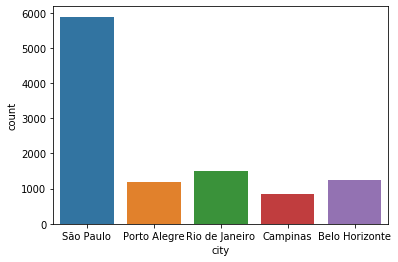

In [5]:
data.city.unique()
sns.countplot(x="city",data=data)

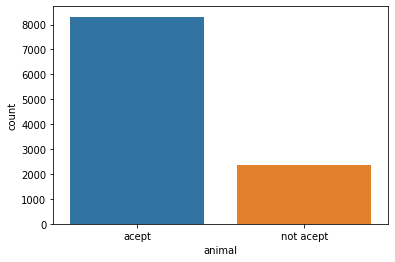

In [6]:
sns.countplot(x="animal",data=data)

The proportion of houses that acept animals is close to 4:1

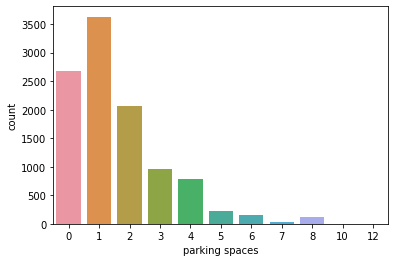

In [7]:
sns.countplot(x="parking spaces",data=data)

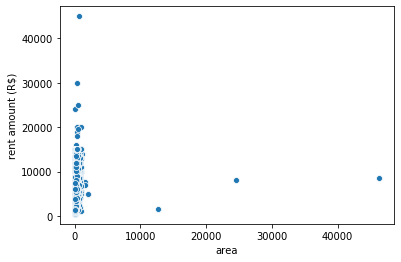

In [185]:
sns.scatterplot(x="area",y="rent amount (R$)",data=data)

### Warning!! Don´t forget to rescale the plots!!

There are some outliers  with huge area and relatively low prices.We have to deal with them in the future.

In [193]:
#Selecting Features
features=["city","area","rooms","bathroom","animal","furniture","hoa (R$)"]
X=data[features]
#Selecting Target
y=data['rent amount (R$)']
y

0         3300
1         4960
2         2800
3         1112
4          800
         ...  
10687     1478
10688    15000
10689     6000
10690    12000
10691     1400
Name: rent amount (R$), Length: 10692, dtype: int64

In [187]:
y.describe()

count    10692.000000
mean      3896.247194
std       3408.545518
min        450.000000
25%       1530.000000
50%       2661.000000
75%       5000.000000
max      45000.000000
Name: rent amount (R$), dtype: float64

In [188]:
from sklearn.model_selection import train_test_split
#Splitting data between train and test
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)


In [190]:
#Importing Encoder to work with categorical features
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
#Choosing features to enconde
object_cols=["city","animal","furniture"]
label_X_train = X_train_full.copy()
label_X_valid = X_valid_full.copy()
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(label_X_train[col])
    label_X_valid[col] = label_encoder.fit_transform(label_X_valid[col])
label_X_valid

,city,area,rooms,bathroom,animal,furniture,hoa (R$)
5474,3,95,3,2,0,1,702
1167,4,100,3,2,1,1,2152
3156,4,130,2,1,0,1,0
124,4,94,3,3,0,0,1220
1158,1,111,3,3,1,0,1000
...,...,...,...,...,...,...,...
5378,1,130,3,2,0,1,0
8636,4,134,3,3,0,0,900
10185,4,36,1,1,1,0,450
8348,4,73,2,2,0,1,700


In [194]:
from  sklearn.ensemble import RandomForestRegressor
#Define model
base_model=RandomForestRegressor(n_estimators=500,max_depth=10,
                                 random_state=42)
#Fitting Model
base_model.fit(label_X_train,y_train)

#Predicting 
predictions=base_model.predict(label_X_valid)

In [192]:
#Evaluating Our Model
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,y_valid)

1369.4237344244054

Two observations here:

- Our present error is not so bad,but can be lowered by cleaning outliers andfeature engineering.
- It´s worth to try crossvalidation scoring in the future.

In [196]:
#Checking first 20 predictions and actual values.
print(predictions[:20])
print(y.head(20))

[ 2102.7025042   4522.43413696  2636.94428532  5118.17405558
  4037.20374078  1609.96530486  7909.09580293  2990.14441596
  2581.02779834  2343.00629351 10764.93166829  1085.82062565
  8563.70575687  9192.21394174  3035.50120269  5643.47251098
  1238.20707288  3166.48618498  1506.99787542  7768.32507271]
0      3300
1      4960
2      2800
3      1112
4       800
5      8000
6      1900
7      3223
8     15000
9      2300
10     2100
11      580
12     2100
13     4200
14     4370
15     8000
16     3000
17     3500
18     1220
19    12000
Name: rent amount (R$), dtype: int64


In [197]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

lr_model.fit(label_X_train,y_train)

linear_pred=lr_model.predict(label_X_valid)

print(mean_absolute_error(linear_pred,y_valid))

1820.5422035770835


In [195]:
#Checking first 20 predictions and actual values
print(linear_pred[:20])
print(y.head(20))

[ 3132.27302435  3656.35759488  2731.9606408   5392.73591635
  4691.56853689  2287.10573816  7764.15492434  3323.59283433
  4239.23266307  1738.93452438 13493.69770253   877.41930425
  8869.23357433  8327.14296191  3626.23415479  6441.26924392
  2129.8682341   3420.55177398  1967.18629316  7839.03370251]
0      3300
1      4960
2      2800
3      1112
4       800
5      8000
6      1900
7      3223
8     15000
9      2300
10     2100
11      580
12     2100
13     4200
14     4370
15     8000
16     3000
17     3500
18     1220
19    12000
Name: rent amount (R$), dtype: int64


As we can see The RandomForest performs reasonably better than the Linear Regression.

# To be continued.